# Advent of Code - 2024 - Day 12 - Problem 2

https://adventofcode.com/2024/day/12

## Load Source Data

Load the map data into `DATA`.

In [1]:
f = open("data/day12.txt", "r")
DATA = list(map(str.strip, f.readlines()))
f.close()

## Create Map Class



In [2]:
class Map:

    def __init__(self):
        self._plants = {}  # {(row,col) : plant}

    def add_plant(self, plant, row, col):
        self._plants[(row, col)] = plant

    def get_regions(self):
        all_regions = []

        # locations maintains the set of unprocessed locations. Elements are removed from this set:
        # 1. When a new region is created
        # 2. When a region is extended (below)
        #
        locations = set(self._plants.keys())
        while locations:  # is not empty
            location = locations.pop()
            plant = self._plants[location]

            region = set()
            all_regions.append(region)

            # Maintain a list of unprocessed locations that will be added to the current region.
            #
            region_locations = set()
            region_locations.add(location)
            while region_locations:  # is not empty
                region_location = region_locations.pop()

                region.add(region_location)

                for adjoining_location in self._get_adjoining_locations(region_location):
                    if adjoining_location in locations and self._plants[adjoining_location] == plant:
                        locations.remove(adjoining_location)
                        region_locations.add(adjoining_location)

        return all_regions

    def _get_adjoining_locations(self, location):
        row, col = location
        return [(row - 1, col), (row, col - 1), (row, col + 1), (row + 1, col)]

## Define get_fence_length

Determines the length of the fence surrounding the specified region.

In [3]:
def get_fence_length(region):
    length = 0
    for row, col in region:

        # Fence above
        if (row - 1, col) not in region:
            # Fence does *not* extend from left
            if not ((row, col - 1) in region and (row - 1, col - 1) not in region):
                length += 1

        # Fence below
        if (row + 1, col) not in region:
            # Fence does *not* extend from left
            if not ((row, col - 1) in region and (row + 1, col - 1) not in region):
                length += 1

        # Fence on left
        if (row, col - 1) not in region:
            # Fences does *not* extend from above
            if not ((row - 1, col) in region and (row - 1, col - 1) not in region):
                length += 1

        # Fence on right
        if (row, col + 1) not in region:
            # Fences does *not* extend from above
            if not ((row - 1, col) in region and (row - 1, col + 1) not in region):
                length += 1

    return length

## Compute Total Price

In [4]:
# Parse the input data and populate the map.
#
m = Map()
for row in range(len(DATA)):
    line = DATA[row]
    for col in range(len(line)):
        plant = line[col]
        m.add_plant(plant, row, col)

# Go through all regions on the map and compute the fence price.
#
total_price = 0
for region in m.get_regions():
    fence_length = get_fence_length(region)
    area = len(region)
    # print(f"fence_length = {fence_length}, area = {area}")
    total_price += fence_length * area

print(f"total_price = {total_price}")

total_price = 830566


## Define get_adjacent_location

In [5]:
def get_adjacent_location(region, location):
    row, col = location
    if (location := (row + 1, col)) in region:
        return location
    if (location := (row - 1, col)) in region:
        return location
    if (location := (row, col + 1)) in region:
        return location
    if (location := (row, col - 1)) in region:
        return location
    return None

## Define get_location_fences

In [6]:
def get_location_fences(location):
    row, col = location
    yield (row, col, row, col + 1)  # top
    yield (row, col + 1, row + 1, col + 1)  # right
    yield (row + 1, col + 1, row + 1, col)  # button
    yield (row + 1, col, row, col)  # left

## Define get_region_fences

In [7]:
def get_region_fences(region):
    region = region.copy()  # Protect input from modification

    fences = set()

    while region:
        location = region.pop()

        for fence in get_location_fences(location):
            from_row, from_col, to_row, to_col = fence
            opposing_fence = (to_row, to_col, from_row, from_col)
            if opposing_fence in fences:
                fences.remove(opposing_fence)
            else:
                fences.add(fence)

    return fences

## Define get_fence_path

In [8]:
def get_sorted_fences(fences):
    fences.copy()  # Protect input from modification

    sorted_fences = list()

    last_fence = None
    while fences:

        if last_fence:

            # Find the next fence
            #
            next_fences = [f for f in fences if f[0] == last_fence[2] and f[1] == last_fence[3]]
            if len(next_fences) == 1:
                next_fence = next_fences[0]
            elif len(next_fences) == 2:  # avoid crossing fences
                possible_fence = next_fences[0]
                if not (  # going in the same direction
                    possible_fence[2] - possible_fence[0] == last_fence[2] - last_fence[0]
                    and possible_fence[3] - possible_fence[1] == last_fence[3] - last_fence[1]
                ):
                    next_fence = possible_fence
                else:  # use the other fence
                    next_fence = next_fences[1]
            else:
                break
                #raise Exception()

            fences.remove(next_fence)
        else:
            next_fence = fences.pop()

        sorted_fences.append(next_fence)
        last_fence = next_fence

    return sorted_fences

## Define get_verticies

Returns a list of verticies which surround the specified region. 

Note: the list of locations is sorted to ensure that we begin with an exterior-adjacent location. Interior locations are omitted from the result.

In [9]:
def get_vertices(region, row_count):

    edges = {}
    for location in sorted(region):
        row, col = location

        # Fence above
        if (row - 1, col) not in region:
            edges[(row, col)] = (row, col + 1)

        # Fence below
        if (row + 1, col) not in region:
            edges[(row + 1, col + 1)] = (row + 1, col)

        # Fence on left
        if (row, col - 1) not in region:
            edges[(row + 1, col)] = (row, col)

        # Fence on right
        if (row, col + 1) not in region:
            edges[(row, col + 1)] = (row + 1, col + 1)

    vertices = []
    vertex = list(edges.keys())[0]
    while vertex in edges:
        row, col = vertex
        vertices.append((col, row_count - row))
        vertex = edges.pop(vertex)

    return vertices

## Render

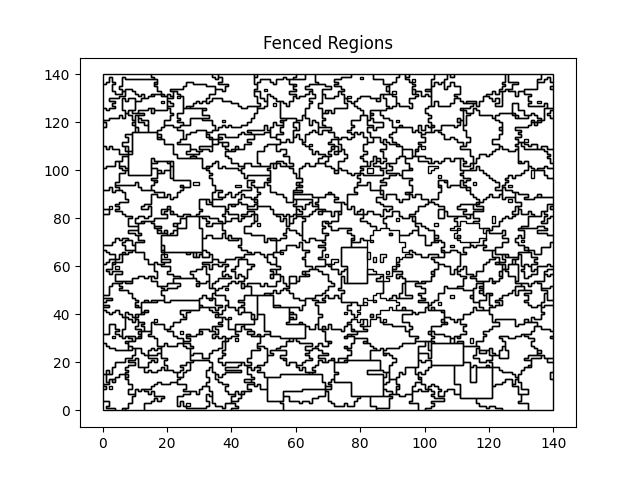

In [10]:
%matplotlib widget

import matplotlib.pyplot as plt

from matplotlib.patches import PathPatch
from matplotlib.path import Path


fig, ax = plt.subplots()

for region in m.get_regions():
    fences = get_sorted_fences(get_region_fences(region))
    vertices = [(f[1], 140-f[0]) for f in fences] + [(0,0)]
    codes = [Path.MOVETO] + [Path.LINETO] * (len(vertices) - 2) + [Path.CLOSEPOLY]
    path = Path(vertices, codes)
    pathpatch = PathPatch(path, facecolor="none", edgecolor="black")
    ax.add_patch(pathpatch)
    # for fence in get_region_fences(region):
    #     from_row, from_col, to_row, to_col = fence
    #     vertices = [(from_col, 140-from_row ), (to_col, 140-to_row)]
    #     codes = [Path.MOVETO, Path.LINETO]
    #     path = Path(vertices, codes)
    #     pathpatch = PathPatch(path, facecolor="none", edgecolor="black")
    #     ax.add_patch(pathpatch)

    # vertices = get_vertices(region, len(DATA)) + [(0,0)]
    # codes = [Path.MOVETO] + [Path.LINETO] * (len(vertices) - 2) + [Path.CLOSEPOLY]
    # path = Path(vertices, codes)
    # pathpatch = PathPatch(path, facecolor="none", edgecolor="black")
    # ax.add_patch(pathpatch)

ax.set_title("Fenced Regions")

ax.autoscale_view()

plt.show()